In [1]:
import nltk
# This command downloads the VADER lexicon file to your NLTK data path
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [7]:
# Import Libraries
import pandas as pd
from transformers import pipeline
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style("whitegrid")

# Define file paths (based on project structure)
CLEAN_DATA_FILE = 'C:/Users/USER/Desktop/Projects/Customer Experience Analytics/Customer-Experience-Analytics/data/processed/clean_bank_reviews.csv'
ANALYSIS_DATA_FILE = 'C:/Users/USER/Desktop/Projects/Customer Experience Analytics/Customer-Experience-Analytics/data/processed/analyzed_bank_reviews.csv'

# --- 1. Initialize Sentiment Models ---

# A. DistilBERT (Primary Requirement [cite: 65])
print("Initializing DistilBERT Sentiment Model...")
sentiment_analyzer_bert = pipeline(
    "sentiment-analysis", 
    model="distilbert-base-uncased-finetuned-sst-2-english"
)
print("DistilBERT Model Ready.")

# B. VADER (Comparison Tool [cite: 65])
vader_analyzer = SentimentIntensityAnalyzer()
print("VADER Analyzer Ready.")

Initializing DistilBERT Sentiment Model...


Device set to use cpu


DistilBERT Model Ready.
VADER Analyzer Ready.


In [8]:
# Load the data from Task 1
try:
    df = pd.read_csv(CLEAN_DATA_FILE)
    print(f"\nSuccessfully loaded {len(df)} clean reviews from Task 1.")
except FileNotFoundError:
    print(f"\n!!! ERROR: Clean data file not found at {CLEAN_DATA_FILE}. Please run Task 1 first.")
    df = pd.DataFrame()


Successfully loaded 1500 clean reviews from Task 1.


In [9]:
def analyze_sentiment_vader(text):
    """
    Applies VADER sentiment analysis and returns the compound score.
    """
    if pd.isna(text):
        return 0.0

    vs = vader_analyzer.polarity_scores(str(text))
    return vs['compound'] # Compound score is VADER's normalized measure


if not df.empty:
    print("\n--- Starting Dual-Model Sentiment Analysis ---")

    # --- A. DistilBERT Analysis (Primary) ---
    print("Starting DistilBERT Analysis...")
    reviews = df['review_text'].tolist()
    
    # Process reviews in batches
    sentiment_results = sentiment_analyzer_bert(reviews, truncation=True, batch_size=32) 

    df['sentiment_label_bert'] = [res['label'] for res in sentiment_results]
    
    # Standardize score to range from -1 (Negative) to 1 (Positive)
    df['sentiment_score_bert'] = [res['score'] if res['label'] == 'POSITIVE' else (1 - res['score']) * -1 
                                 for res in sentiment_results] 
    
    # --- B. VADER Analysis (Comparison) ---
    print("Starting VADER Analysis...")
    df['sentiment_score_vader'] = df['review_text'].apply(analyze_sentiment_vader)
    
    # Derive the VADER label for comparison
    df['sentiment_label_vader'] = df['sentiment_score_vader'].apply(
        lambda x: 'POSITIVE' if x >= 0.05 else ('NEGATIVE' if x <= -0.05 else 'NEUTRAL')
    )
    
    print("Scores Computed. Setting final columns to DistilBERT results.")
    
    # Set final columns (Must be BERT based on requirement)
    df['sentiment_label'] = df['sentiment_label_bert']
    df['sentiment_score'] = df['sentiment_score_bert']
    
    # Display comparison
    print("\nSample Comparison (BERT vs. VADER):")
    display(df[['review_text', 'sentiment_label_bert', 'sentiment_label_vader', 'sentiment_score']].sample(5))


--- Starting Dual-Model Sentiment Analysis ---
Starting DistilBERT Analysis...


Starting VADER Analysis...
Scores Computed. Setting final columns to DistilBERT results.

Sample Comparison (BERT vs. VADER):


,review_text,sentiment_label_bert,sentiment_label_vader,sentiment_score
390,best app and easy to use,POSITIVE,POSITIVE,0.999628
1120,Best application,POSITIVE,POSITIVE,0.999810
370,love it,POSITIVE,POSITIVE,0.999875
1205,It is good apps but it needs strong network,NEGATIVE,POSITIVE,-0.029655
176,ዳር ኑሮ ላለው ኣፍሪቻን ው,NEGATIVE,NEUTRAL,-0.116787


In [10]:
# --- Thematic Analysis Rule-Based Logic (5 Themes) ---
THEME_MAPPING = {
    'Transaction Performance': ['slow', 'transfer', 'speed', 'load', 'delay', 'fast', 'quick', 'payment', 'send money'],
    'UI/UX & Design': ['easy to use', 'user friendly', 'interface', 'design', 'navigation', 'look and feel', 'update', 'difficult', 'clunky'],
    'Account Access & Security': ['login', 'log in', 'fingerprint', 'password', 'access', 'security', 'otp', 'verification', 'locked', 'm-banking'],
    'Bugs/Errors & Stability': ['crash', 'bug', 'error', 'not working', 'malfunction', 'force close', 'issue', 'glitch', 'problem'],
    'Customer Support': ['support', 'customer service', 'help desk', 'call center', 'respond', 'representative', 'hotline'],
}

def identify_theme(text):
    """Maps review text to one of the 5 themes based on keyword matching."""
    if pd.isna(text):
        return 'General Feedback'
        
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text) 
    
    for theme, keywords in THEME_MAPPING.items():
        for keyword in keywords:
            if keyword in text:
                return theme
    return 'General Feedback'

if not df.empty:
    print("\n--- Starting Thematic Analysis ---")
    df['identified_theme'] = df['review_text'].apply(identify_theme)
    
    theme_counts = df['identified_theme'].value_counts()
    print(f"Themes identified and clustered into: {theme_counts.nunique()} categories.")
    print("Top Themes Identified:")
    display(theme_counts.head(5))


--- Starting Thematic Analysis ---
Themes identified and clustered into: 6 categories.
Top Themes Identified:


identified_theme
General Feedback             1156
Transaction Performance       170
UI/UX & Design                 92
Bugs/Errors & Stability        49
Account Access & Security      30
Name: count, dtype: int64


--- Aggregation: Mean Sentiment by Bank and Rating ---
Mean Sentiment Score per Bank, per Star Rating:
(Score close to 1.0 = Positive, close to -1.0 = Negative)


rating,1,2,3,4,5
bank,,,,,
BOA,0.043,0.079,0.350,0.392,0.697
CBE,0.164,0.159,0.355,0.583,0.757
Dashen,0.088,0.138,0.328,0.600,0.846


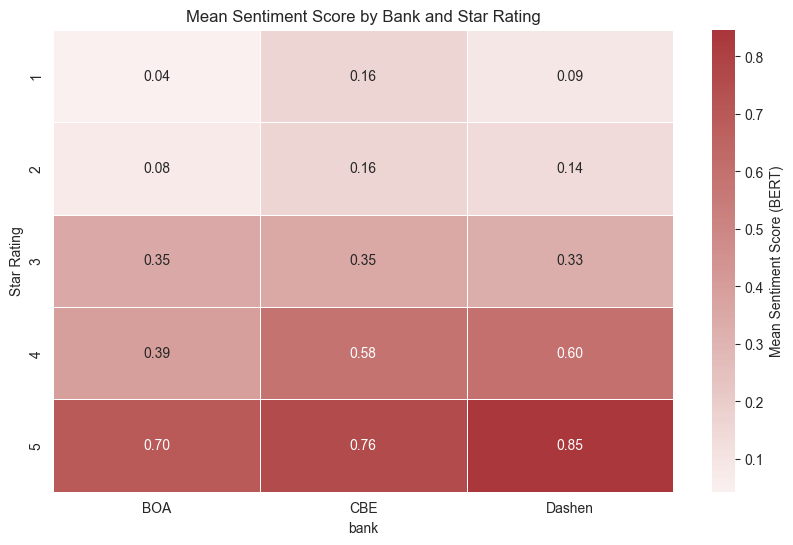

In [11]:
if not df.empty:
    print("\n--- Aggregation: Mean Sentiment by Bank and Rating ---")
    
    # Ensure rating is treated as an integer
    df['rating'] = df['rating'].astype(int) 

    # Aggregate: Group by bank and rating, calculate mean sentiment score
    sentiment_agg = df.groupby(['bank', 'rating'])['sentiment_score'].mean().unstack(fill_value=0)
    
    print("Mean Sentiment Score per Bank, per Star Rating:")
    print("(Score close to 1.0 = Positive, close to -1.0 = Negative)")
    display(sentiment_agg.round(3))
    
    # Visualization of Aggregation
    plt.figure(figsize=(10, 6))
    sns.heatmap(sentiment_agg.T, annot=True, fmt=".2f", cmap="vlag", center=0, linewidths=.5, cbar_kws={'label': 'Mean Sentiment Score (BERT)'})
    plt.title('Mean Sentiment Score by Bank and Star Rating')
    plt.ylabel('Star Rating')
    plt.show()

In [12]:
if not df.empty:
    # Save the enriched data
    df.to_csv(ANALYSIS_DATA_FILE, index=False)
    print(f"\n--- Task 2 Completed Successfully ---")
    print(f"Analyzed data saved to: {ANALYSIS_DATA_FILE}")


--- Task 2 Completed Successfully ---
Analyzed data saved to: C:/Users/USER/Desktop/Projects/Customer Experience Analytics/Customer-Experience-Analytics/data/processed/analyzed_bank_reviews.csv
